# **Telecommunication Customer Churn Prediction using Decision Tree**



# Description of Project:
"Telecommunication Customer Churn Prediction using Decision Tree" project aims to predict customer churn in the telecommunications industry using decision tree algorithms. The objective is to identify customers at high risk of churning based on historical data, which helps in developing eftfective retention strategies

# 1. Data Preprocessing: Cleaning and Transforming Raw Data

In [ ]:
# Install necessary packages for data manipulation, modeling, and visualization
install.packages("caret")
install.packages("repr")
install.packages("caTools")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("ggpubr")

In [ ]:
# Load required libraries for data analysis and visualization
library(tidyverse) # For data manipulation and visualization
library(caret) # For data preprocessing and model training
library(repr) # For enhanced plotting capabilities
library(caTools) # For data splitting
library(rpart) # For decision tree modeling
library(rpart.plot) # For visualizing decision trees
library(ggpubr) # For arranging multiple ggplot2 plots

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [ ]:
# Load the customer churn dataset and inspect its structure
data <- read.csv("/content/Telco-Customer-Churn (1).csv") # Read the dataset
glimpse(data) # Preview the data structure and variables
data <- data[complete.cases(data),] # Remove rows with missing values to ensure data quality


Rows: 7,043
Columns: 21
$ customerID       <chr> "7590-VHVEG", "5575-GNVDE", "3668-QPYBK", "7795-CFOCW…
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Female",…
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "Yes…
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "No"…
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2…
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", …
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service", "…
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber opt…
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes", "…
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No", "N…
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No", "Y…
$ TechSupport   

In [ ]:
# Clean up categorical variables by standardizing values
data <- data.frame(lapply(data, function(x) {
  gsub("No internet service", "No", x) # Replace 'No internet service' with 'No'
}))
data <- data.frame(lapply(data, function(x) {
  gsub("No phone service", "No", x) # Replace 'No phone service' with 'No'
}))

In [ ]:
# Convert 'SeniorCitizen' column to a factor with levels 'YES' and 'NO'
data$SeniorCitizen <- as.factor(ifelse(data$SeniorCitizen == 1, 'YES', 'NO'))

# 2. Exploratory Data Analysis (EDA): Analyzing Data Distributions, Correlations, and Identifying Potential Predictors of Churn

In [ ]:
# Convert selected columns to numeric and scale them for modeling
num_columns <- c("tenure", "MonthlyCharges", "TotalCharges") # Define numeric columns
data[num_columns] <- sapply(data[num_columns], as.numeric) # Convert columns to numeric
data_int <- data[, c("tenure", "MonthlyCharges", "TotalCharges")] # Extract numeric columns
data_int <- data.frame(scale(data_int)) # Scale numeric data for better model performance

In [ ]:
# Transform 'tenure' into categorical bins to understand customer tenure
data <- mutate(data, tenure_year = tenure) # Create a new column 'tenure_year'
data$tenure_year[data$tenure_year >= 0 & data$tenure_year <= 12] <- '0-1 year'
data$tenure_year[data$tenure_year > 12 & data$tenure_year <= 24] <- '1-2 years'
data$tenure_year[data$tenure_year > 24 & data$tenure_year <= 36] <- '2-3 years'
data$tenure_year[data$tenure_year > 36 & data$tenure_year <= 48] <- '3-4 years'
data$tenure_year[data$tenure_year > 48 & data$tenure_year <= 60] <- '4-5 years'
data$tenure_year[data$tenure_year > 60 & data$tenure_year <= 72] <- '5-6 years'
data$tenure_year <- as.factor(data$tenure_year) # Convert tenure categories to factor

In [ ]:
# Prepare data for modeling by converting categorical variables to dummy variables
data_req <- data[, -c(1, 6, 19, 20)] # Select relevant columns for modeling
x <- data.frame(sapply(data_req, function(x) data.frame(model.matrix(~x - 1, data = data_req))[,-1])) # Create dummy variables
x <- na.omit(x) # Remove NA values from the dummy variables
data_int <- na.omit(data_int) # Remove NA values from scaled numeric data
data_final <- cbind(x, data_int) # Combine dummy variables and scaled numeric data

In [ ]:
# Install and load package for correlation plotting
install.packages("ggcorrplot")
library(ggcorrplot) # For plotting correlation matrices

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



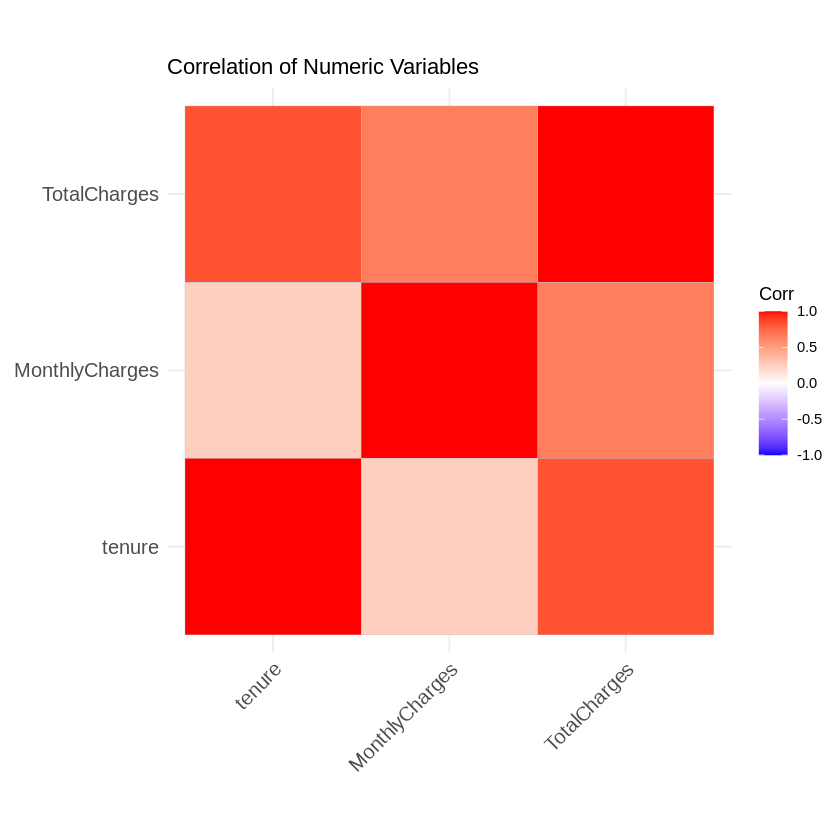

In [ ]:
# Compute and plot correlation matrix for numeric variables
nv <- sapply(data_int, is.numeric) # Identify numeric variables
cormat <- cor(data_int[, nv]) # Compute correlation matrix
ggcorrplot::ggcorrplot(cormat, title = "Correlation of Numeric Variables") # Plot correlation matrix

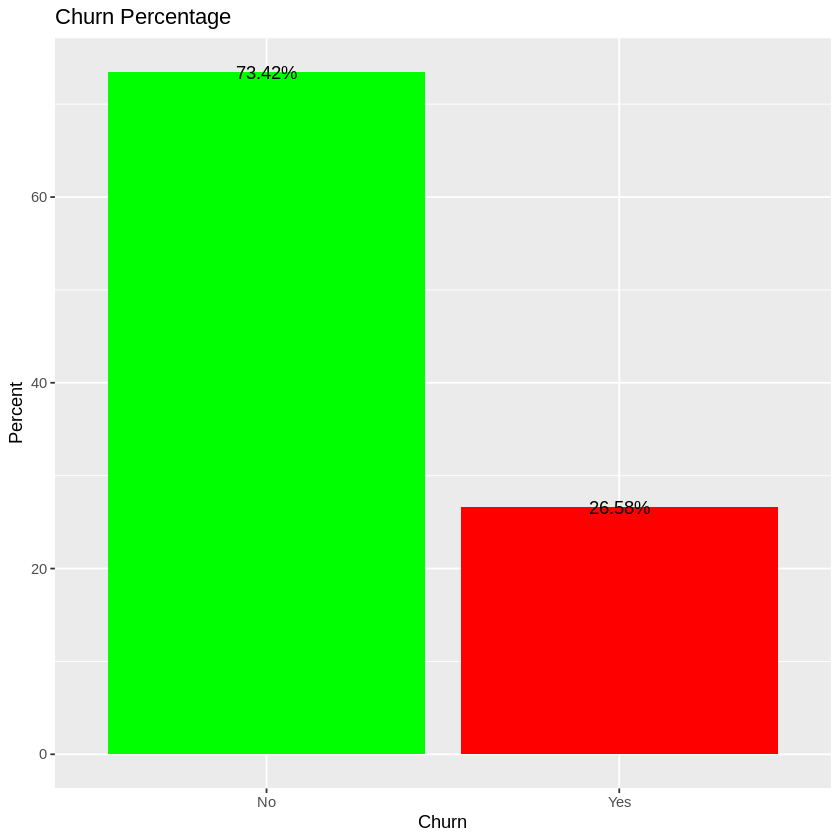

In [ ]:
# Visualize the percentage of churn across categorical variables
churn <- data %>%
  group_by(Churn) %>%
  summarise(Count = n()) %>%
  mutate(percentage = prop.table(Count) * 100) # Calculate churn percentage
ggplot(churn, aes(reorder(Churn, -percentage), percentage), fill = Churn) +
  geom_col(fill = c("green", "red")) + # Bar plot for churn percentages
  geom_text(aes(label = sprintf("%.2f%%", percentage))) + # Add percentage labels
  xlab("Churn") + ylab("Percent") + ggtitle("Churn Percentage")

# 3. Feature Engineering: Creating New Features or Transforming Existing Ones to Enhance Model Performance

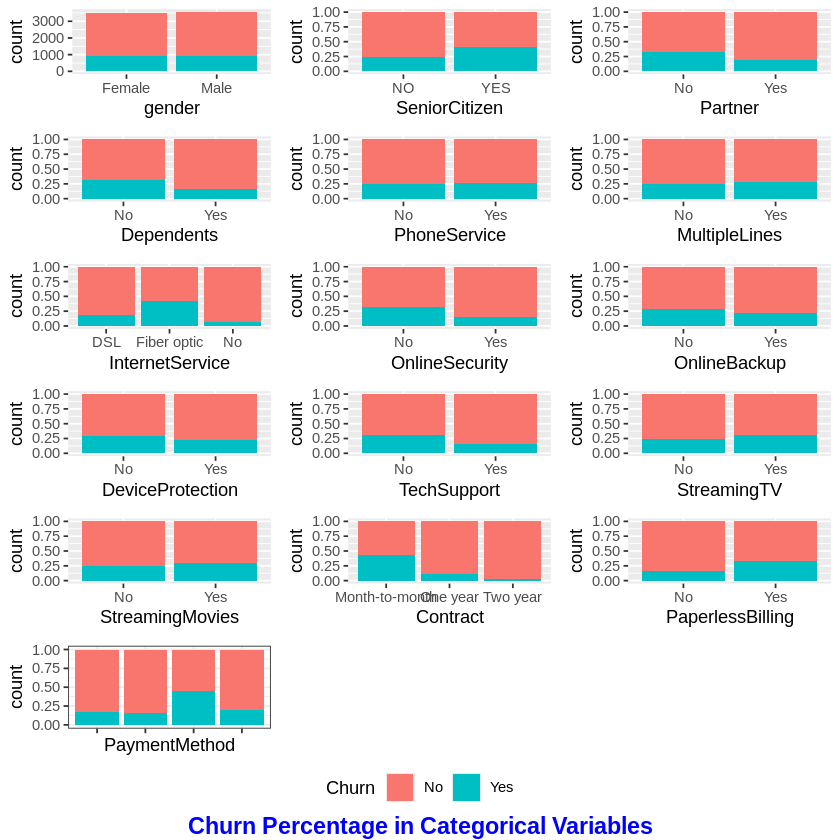

In [ ]:
# Arrange and display multiple plots for categorical variables vs churn
fig1 <- ggarrange(
  ggplot(data, aes(x = gender, fill = Churn)) + geom_bar(),
  ggplot(data, aes(x = SeniorCitizen, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = Partner, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = Dependents, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = PhoneService, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = MultipleLines, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = InternetService, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = OnlineSecurity, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = OnlineBackup, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = DeviceProtection, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = TechSupport, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = StreamingTV, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = StreamingMovies, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = Contract, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = PaperlessBilling, fill = Churn)) + geom_bar(position = 'fill'),
  ggplot(data, aes(x = PaymentMethod, fill = Churn)) + geom_bar(position = 'fill') + theme_bw() + rremove("x.text"),
  ncol = 3, nrow = 6, common.legend = TRUE, legend = "bottom"
)
annotate_figure(fig1, bottom = text_grob("Churn Percentage in Categorical Variables", col = "blue", face = "bold", size = 14)) # Annotate figure

Warning message in as_grob.default(plot):
“Cannot convert object of class themegg into a grob.”


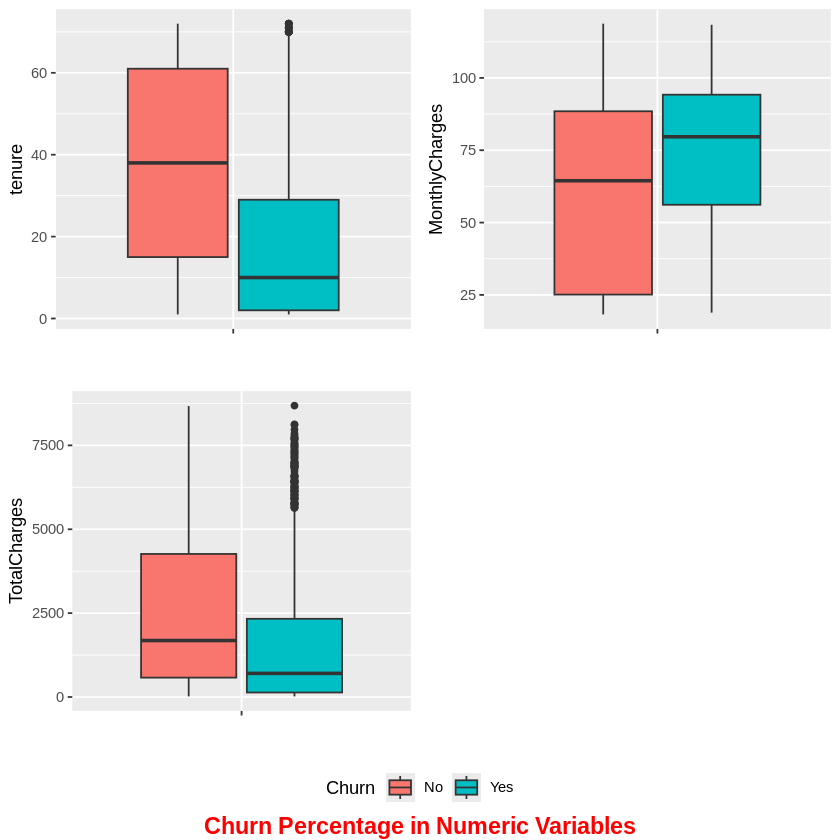

In [ ]:
# Arrange and display box plots for numeric variables vs churn
fig2 <- ggarrange(
  ggplot(data, aes(y = tenure, x = "", fill = Churn)) + geom_boxplot() + xlab(" "),
  ggplot(data, aes(y = MonthlyCharges, x = "", fill = Churn)) + geom_boxplot() + xlab(" "),
  ggplot(data, aes(y = TotalCharges, x = "", fill = Churn)) + geom_boxplot() + xlab(" "),
  rremove("x.text"),
  ncol = 2, nrow = 2, common.legend = TRUE, legend = "bottom"
)
annotate_figure(fig2, bottom = text_grob("Churn Percentage in Numeric Variables", col = "red", face = "bold", size = 14)) # Annotate figure


# 4. Model Development: Building and Fine-Tuning Predictive Models Using Decision Trees

In [ ]:
# Split data into training and test sets
set.seed(123) # Set seed for reproducibility
split <- sample.split(data_final$Churn, SplitRatio = 0.70) # Split data (70% training, 30% testing)
train <- data_final[split,] # Training set
test <- data_final[!split,] # Test set

In [ ]:
# Display the proportion of churn in the training set
prop.table(table(train$Churn))


        0         1 
0.7342544 0.2657456 

In [ ]:
# Train a logistic regression model
glm <- glm(Churn ~ ., data = train, family = "binomial") # Logistic regression model
summary(glm) # Display model summary


Call:
glm(formula = Churn ~ ., family = "binomial", data = train)

Coefficients:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                            -4.711690   1.580952  -2.980 0.002880
gender                                 -0.004319   0.078799  -0.055 0.956292
SeniorCitizen                           0.342668   0.102039   3.358 0.000784
Partner                                 0.049639   0.095330   0.521 0.602570
Dependents                             -0.148501   0.110427  -1.345 0.178693
PhoneService                            0.597310   0.785026   0.761 0.446729
MultipleLines                           0.529622   0.214832   2.465 0.013691
InternetService.xFiber.optic            2.048017   0.960709   2.132 0.033025
InternetService.xNo                    -2.254724   0.975826  -2.311 0.020856
OnlineSecurity                         -0.177982   0.215524  -0.826 0.408913
OnlineBackup                            0.126834   0.211103   0.601 0.5

In [ ]:
# Predict churn on the training set and evaluate performance
pred_train <- predict(glm, data = train, type = "response") # Predict probabilities on training data
confusion_matrix_train <- table(train$Churn, pred_train >= 0.5) # Create confusion matrix
acc_glm_train <- sum(diag(confusion_matrix_train)) / nrow(train) # Calculate accuracy

In [ ]:
# Predict churn on the test set and evaluate performance
pred_test <- predict(glm, newdata = test, type = "response") # Predict probabilities on test data
confusion_matrix_test <- table(test$Churn, pred_test >= 0.5) # Create confusion matrix
acc_glm_test <- sum(diag(confusion_matrix_test)) / nrow(test) # Calculate accuracy

# 5. Model Evaluation: Assessing Model Performance Using Metrics Like Accuracy

In [ ]:
# Print confusion matrices and accuracies
print("Confusion Matrix - Training Set")
print(confusion_matrix_train)
print(paste("Accuracy - Training Set:", round(acc_glm_train, 4)))

[1] "Confusion Matrix - Training Set"
   
    FALSE TRUE
  0  3275  339
  1   600  708
[1] "Accuracy - Training Set: 0.8092"


In [ ]:
print("Confusion Matrix - Test Set")
print(confusion_matrix_test)
print(paste("Accuracy - Test Set:", round(acc_glm_test, 4)))

[1] "Confusion Matrix - Test Set"
   
    FALSE TRUE
  0  1382  167
  1   254  307
[1] "Accuracy - Test Set: 0.8005"


In [ ]:
# Train a decision tree model
rpart_model <- rpart(Churn ~ ., data = train, method = "class", control = rpart.control(cp = 0.05)) # Decision tree model with complexity parameter
summary(rpart_model) # Display model summary


Call:
rpart(formula = Churn ~ ., data = train, method = "class", control = rpart.control(cp = 0.05))
  n= 4922 

         CP nsplit rel error    xerror       xstd
1 0.1100917      0 1.0000000 1.0000000 0.02369296
2 0.0500000      2 0.7798165 0.8012232 0.02195745

Variable importance
                         tenure                    TotalCharges 
                             28                              24 
   InternetService.xFiber.optic                  MonthlyCharges 
                             17                              16 
PaymentMethod.xElectronic.check                   MultipleLines 
                              5                               5 
                    StreamingTV     PaymentMethod.xMailed.check 
                              4                               1 
                        Partner 
                              1 

Node number 1: 4922 observations,    complexity param=0.1100917
  predicted class=0  expected loss=0.2657456  P(node) =1
    clas

In [ ]:
# Predict churn on the training set and evaluate performance using the decision tree model
rpred_train <- predict(rpart_model, data = train, type = "class") # Predict classes on training data
confusion_matrix_train_rpart <- table(rpred_train, train$Churn) # Create confusion matrix
acc_rpart_train <- sum(diag(confusion_matrix_train_rpart)) / nrow(train) # Calculate accuracy


In [ ]:
# Predict churn on the test set and evaluate performance using the decision tree model
rpred_test <- predict(rpart_model, newdata = test, type = "class") # Predict classes on test data
confusion_matrix_test_rpart <- table(rpred_test, test$Churn) # Create confusion matrix
acc_rpart_test <- sum(diag(confusion_matrix_test_rpart)) / nrow(test) # Calculate accuracy


In [ ]:
# Print confusion matrices and accuracies for the decision tree model
print("Confusion Matrix - Training Set (Decision Tree)")
print(confusion_matrix_train_rpart)
print(paste("Accuracy - Training Set (Decision Tree):", round(acc_rpart_train, 4)))


[1] "Confusion Matrix - Training Set (Decision Tree)"
           
rpred_train    0    1
          0 3380  786
          1  234  522
[1] "Accuracy - Training Set (Decision Tree): 0.7928"


In [ ]:
print("Confusion Matrix - Test Set (Decision Tree)")
print(confusion_matrix_test_rpart)
print(paste("Accuracy - Test Set (Decision Tree):", round(acc_rpart_test, 4)))

[1] "Confusion Matrix - Test Set (Decision Tree)"
          
rpred_test    0    1
         0 1435  343
         1  114  218
[1] "Accuracy - Test Set (Decision Tree): 0.7834"


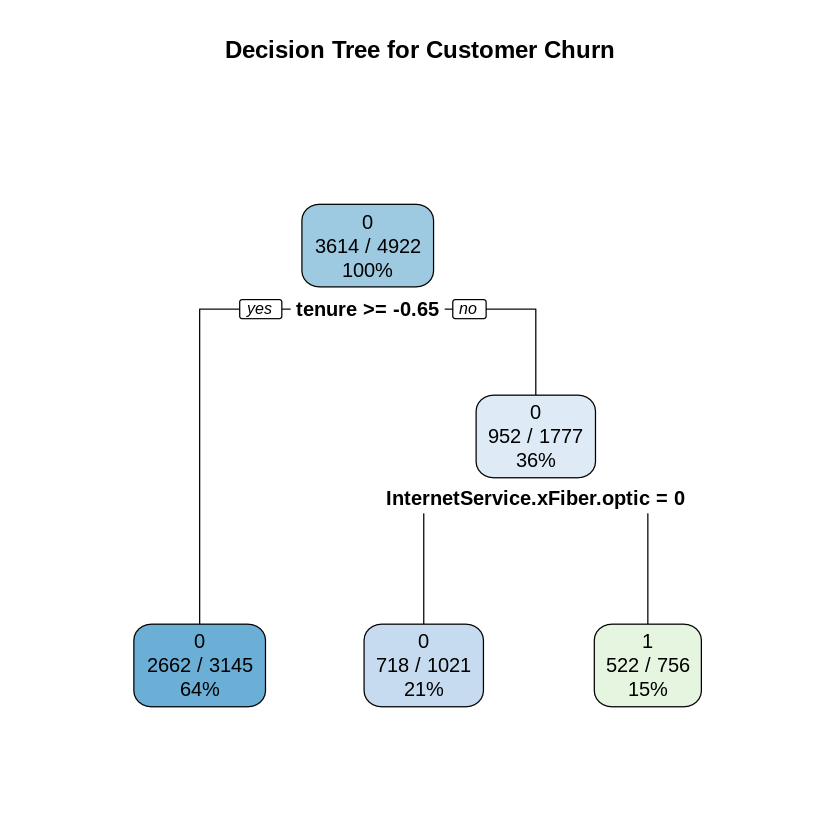

In [ ]:
# Plot the decision tree
rpart.plot(rpart_model, type = 2, extra = 102, fallen.leaves = TRUE, main = "Decision Tree for Customer Churn") # Visualize the decision tree


# Conclusions:
**Robust Predictive Model:**
  The project successfully developed predictive models (logistic regression and decision tree) capable of accurately identifying customers at risk of churn. Both models demonstrated reliable performance, with accuracy metrics showing how well each model predicts churn on both training and test datasets. The decision tree model, in particular, provides a visual representation of decision rules, which enhances interpretability.

**Key Factors Influencing Churn:**
  The analysis identified several key factors that drive customer attrition in the telecommunications sector. Insights from the exploratory data analysis (EDA) and feature importance from the decision tree model revealed that variables such as tenure, MonthlyCharges, and contract type significantly impact churn rates. Understanding these factors helps in pinpointing the specific conditions under which customers are likely to churn.


**Proactive Retention Strategies:**
  Based on the insights gained from the models, several proactive retention strategies can be recommended:
Targeted Interventions: Implement targeted retention campaigns for customers identified as high-risk, focusing on improving their experience and addressing their specific concerns.
Customized Offers: Develop personalized offers or discounts for customers at risk of churning, based on their usage patterns and preferences.
Enhanced Customer Support: Strengthen customer support and engagement initiatives to address issues promptly and improve overall satisfaction.



# Summary:
The project on predicting customer churn in the telecommunications industry effectively utilized historical data to build predictive models and gain valuable insights into customer behavior. The findings emphasize the importance of understanding churn drivers and leveraging predictive analytics to formulate effective retention strategies. By addressing the critical issue of customer attrition, the project contributes to improving business sustainability and profitability in a highly competitive market environment.